# ROCK SHI ASSIGNMENT 39

In [229]:
try:
    sc.stop()
except:
    pass

In [230]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import numpy as np
from pyspark.sql.functions import when
from pyspark.mllib.stat import Statistics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.sql.types import *


sc = SparkContext()
spark = SparkSession(sparkContext = sc)

# Breast Cancer

In [231]:
schema = StructType([
    StructField('id', IntegerType()),
    StructField('clump_thickness', IntegerType()),
    StructField('unif_cell_size', IntegerType()),
    StructField('unif_cell_shape', IntegerType()),
    StructField('marginal_adhesion', IntegerType()),
    StructField('single_epith_cell_size', IntegerType()),
    StructField('bare_nuclei', StringType()),
    StructField('bland_chromatin', IntegerType()),
    StructField('normal_nucleoli', IntegerType()),
    StructField('mitoses', IntegerType()),
    StructField('Mal_Class', IntegerType())
])

In [232]:
breast_cancer = spark.read.csv('file:///home/hadoop/Downloads/brest_cancer.csv', schema = schema)

In [233]:
breast_cancer.show(5)

+-------+---------------+--------------+---------------+-----------------+----------------------+-----------+---------------+---------------+-------+---------+
|     id|clump_thickness|unif_cell_size|unif_cell_shape|marginal_adhesion|single_epith_cell_size|bare_nuclei|bland_chromatin|normal_nucleoli|mitoses|Mal_Class|
+-------+---------------+--------------+---------------+-----------------+----------------------+-----------+---------------+---------------+-------+---------+
|1000025|              5|             1|              1|                1|                     2|          1|              3|              1|      1|        2|
|1002945|              5|             4|              4|                5|                     7|         10|              3|              2|      1|        2|
|1015425|              3|             1|              1|                1|                     2|          2|              3|              1|      1|        2|
|1016277|              6|             8|

In [234]:
breast_cancer.printSchema()

root
 |-- id: integer (nullable = true)
 |-- clump_thickness: integer (nullable = true)
 |-- unif_cell_size: integer (nullable = true)
 |-- unif_cell_shape: integer (nullable = true)
 |-- marginal_adhesion: integer (nullable = true)
 |-- single_epith_cell_size: integer (nullable = true)
 |-- bare_nuclei: string (nullable = true)
 |-- bland_chromatin: integer (nullable = true)
 |-- normal_nucleoli: integer (nullable = true)
 |-- mitoses: integer (nullable = true)
 |-- Mal_Class: integer (nullable = true)



In [235]:
breast_cancer.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,699,1071704.0987124464,617095.7298192448,61634,13454352
clump_thickness,699,4.417739628040057,2.815740658594933,1,10
unif_cell_size,699,3.13447782546495,3.0514591099542003,1,10
unif_cell_shape,699,3.207439198855508,2.9719127672157133,1,10
marginal_adhesion,699,2.8068669527896994,2.855379239217023,1,10
single_epith_cell_size,699,3.216022889842632,2.214299886649047,1,10
bare_nuclei,699,3.5446559297218156,3.643857160492912,1,?
bland_chromatin,699,3.4377682403433476,2.4383642523242512,1,10
normal_nucleoli,699,2.866952789699571,3.0536338936127745,1,10


In [236]:
def compute_corr_matrix(df, method = 'pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method = method)
    
    corr_mat_df = pd.DataFrame(corr_mat, columns = df.columns, index = df.columns)
    
    return corr_mat_df

In [237]:
breast_cancer = breast_cancer.drop('id','bare_nuclei')
cols = breast_cancer.columns
cols.remove('Mal_Class')

In [238]:
compute_corr_matrix(breast_cancer)

,clump_thickness,unif_cell_size,unif_cell_shape,marginal_adhesion,single_epith_cell_size,bland_chromatin,normal_nucleoli,mitoses,Mal_Class
clump_thickness,1.000000,0.644913,0.654589,0.486356,0.521816,0.558428,0.535835,0.350034,0.716001
unif_cell_size,0.644913,1.000000,0.906882,0.705582,0.751799,0.755721,0.722865,0.458693,0.817904
unif_cell_shape,0.654589,0.906882,1.000000,0.683079,0.719668,0.735948,0.719446,0.438911,0.818934
marginal_adhesion,0.486356,0.705582,0.683079,1.000000,0.599599,0.666715,0.603352,0.417633,0.696800
single_epith_cell_size,0.521816,0.751799,0.719668,0.599599,1.000000,0.616102,0.628881,0.479101,0.682785
bland_chromatin,0.558428,0.755721,0.735948,0.666715,0.616102,1.000000,0.665878,0.344169,0.756616
normal_nucleoli,0.535835,0.722865,0.719446,0.603352,0.628881,0.665878,1.000000,0.428336,0.712244
mitoses,0.350034,0.458693,0.438911,0.417633,0.479101,0.344169,0.428336,1.000000,0.423170
Mal_Class,0.716001,0.817904,0.818934,0.696800,0.682785,0.756616,0.712244,0.423170,1.000000


In [239]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = cols, outputCol = 'features')
breast_cancer = assembler.transform(breast_cancer)
breast_cancer.select('features').show(5, truncate = False)

+---------------------------------+
|features                         |
+---------------------------------+
|[5.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0]|
|[5.0,4.0,4.0,5.0,7.0,3.0,2.0,1.0]|
|[3.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0]|
|[6.0,8.0,8.0,1.0,3.0,3.0,7.0,1.0]|
|[4.0,1.0,1.0,3.0,2.0,3.0,1.0,1.0]|
+---------------------------------+
only showing top 5 rows



In [240]:
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
breast_cancer=standardscaler.fit(breast_cancer).transform(breast_cancer)
breast_cancer.select("features", "Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[5.0,1.0,1.0,1.0,...|[1.77573171901954...|
|[5.0,4.0,4.0,5.0,...|[1.77573171901954...|
|[3.0,1.0,1.0,1.0,...|[1.06543903141172...|
|[6.0,8.0,8.0,1.0,...|[2.13087806282345...|
|[4.0,1.0,1.0,3.0,...|[1.42058537521563...|
+--------------------+--------------------+
only showing top 5 rows



In [241]:
train, test = breast_cancer.randomSplit([0.8,0.2], seed = 2)

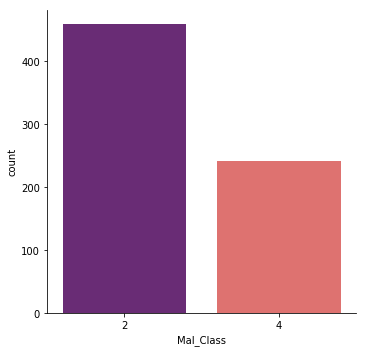

In [242]:
sns.catplot( x = 'Mal_Class', kind = 'count', data = breast_cancer.toPandas(), palette='magma')

In [243]:
dataset_size = float(train.select('Mal_Class').count())
numPositives = train.select("Mal_Class").where("Mal_Class == 4").count()
per_one = (float(numPositives)/float(dataset_size))*100
print("The number of malignant are: {}".format(numPositives))
print("Percentage of malignant are: {}".format(per_one))

The number of malignant are: 192
Percentage of malignant are: 33.92226148409894


In [244]:
numNegatives = float(dataset_size - numPositives)

BalanceRatio = numNegatives / dataset_size

print("BalanceRatio = {}".format(BalanceRatio))

BalanceRatio = 0.6607773851590106


In [245]:
train = train.withColumn("classWeights", when(train.Mal_Class == 4, BalanceRatio).otherwise(1 - BalanceRatio))
train.select("classWeights").show()

+-------------------+
|       classWeights|
+-------------------+
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
|0.33922261484098937|
+-------------------+
only showing top 20 rows



In [246]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = 'Mal_Class', featuresCol = 'features', weightCol = 'classWeights', maxIter = 20)

In [247]:
model = lr.fit(train)

In [248]:
predict_train = model.transform(train)
predict_test = model.transform(test)

In [249]:
predict_test.select("Mal_Class", 'prediction').show()

+---------+----------+
|Mal_Class|prediction|
+---------+----------+
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
|        2|       2.0|
+---------+----------+
only showing top 20 rows



In [250]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'Mal_Class', predictionCol = "prediction",
                                             metricName = "accuracy")

accuracy = evaluator.evaluate(predict_test)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9774436090225563


In [251]:
y_true = predict_test.select("Mal_Class")
y_true = y_true.toPandas()

y_pred = predict_test.select("prediction")
y_pred = y_pred.toPandas()

confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat

array([[84,  0],
       [ 3, 46]])

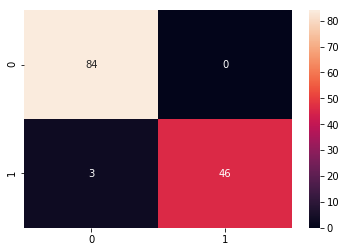

In [252]:
sns.heatmap(confusion_mat, annot = True)

# Churn

In [253]:
churn = spark.read.csv('file:///home/hadoop/Downloads/churn-bigml-20.csv', sep = ',', header = True, inferSchema = True)

In [254]:
churn.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

In [255]:
churn.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [256]:
churn = churn.drop('State')
churn_df = churn.toPandas()
international_plan = pd.get_dummies(churn_df['International plan'])
churn_df = pd.concat([churn_df, international_plan], axis = 1)
churn_df.drop(['International plan'], axis = 1, inplace = True)
churn_df.drop(['No'], axis = 1, inplace = True)
churn_df.rename(columns = {"Yes":'InternationalPlan'}, inplace = True)

voicemail_plan = pd.get_dummies(churn_df['Voice mail plan'])
churn_df = pd.concat([churn_df, voicemail_plan], axis = 1)
churn_df.drop(['Voice mail plan'], axis = 1, inplace = True)
churn_df.drop(['No'], axis = 1, inplace = True)
churn_df.rename(columns = {"Yes":'VoicemailPlan'}, inplace = True)

churn_or_no = pd.get_dummies(churn_df['Churn'])
churn_df = pd.concat([churn_df, churn_or_no], axis = 1)
churn_df.drop(['Churn'], axis = 1, inplace = True)
churn_df.drop([False], axis = 1, inplace = True)
churn_df.rename(columns = {True:'Churn'}, inplace = True)

churn = spark.createDataFrame(churn_df)


In [257]:
churn.show(5)

+--------------+---------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----------------+-------------+-----+
|Account length|Area code|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|InternationalPlan|VoicemailPlan|Churn|
+--------------+---------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----------------+-------------+-----+
|           117|      408|     

In [258]:
churn.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,667,102.84107946026987,40.81948017302251,1,232
Area code,667,436.15742128935534,41.783304688566986,408,510
Number vmail messages,667,8.407796101949025,13.994479792227358,0,51
Total day minutes,667,180.94812593703162,55.5086277572381,25.9,334.3
Total day calls,667,100.93703148425787,20.39679048393531,30,165
Total day charge,667,30.76176911544226,9.436463453602565,4.4,56.83
Total eve minutes,667,203.35532233883058,49.71926848382941,48.1,361.8
Total eve calls,667,100.4767616191904,18.948261696761932,37,168
Total eve charge,667,17.285262368815598,4.226160133395478,4.09,30.75


In [259]:
compute_corr_matrix(churn)

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,InternationalPlan,VoicemailPlan,Churn
Account length,1.000000,-0.026327,-0.011993,0.017833,0.035703,0.017839,0.027043,0.021237,0.027051,-0.007527,0.027228,-0.007528,0.002362,0.031279,0.002456,-0.027677,0.029549,0.003918,0.012315
Area code,-0.026327,1.000000,-0.006907,0.051507,-0.008972,0.051492,0.017160,0.017783,0.017182,-0.016832,0.036421,-0.016818,-0.037980,-0.010530,-0.038044,0.000103,0.053461,-0.032253,0.027129
Number vmail messages,-0.011993,-0.006907,1.000000,-0.069172,-0.009952,-0.069187,0.040865,-0.051951,0.040876,0.039751,0.003367,0.039680,0.029949,-0.036847,0.029999,0.007859,0.023145,0.956168,-0.102381
Total day minutes,0.017833,0.051507,-0.069172,1.000000,-0.032306,1.000000,0.017987,0.043219,0.017945,-0.031600,0.052761,-0.031603,-0.006725,0.016597,-0.006841,0.029291,0.050915,-0.060599,0.242781
Total day calls,0.035703,-0.008972,-0.009952,-0.032306,1.000000,-0.032319,-0.004688,0.005851,-0.004664,0.079536,-0.030074,0.079529,-0.015319,-0.005155,-0.015201,-0.045953,0.040889,-0.025318,0.019360
Total day charge,0.017839,0.051492,-0.069187,1.000000,-0.032319,1.000000,0.017983,0.043231,0.017941,-0.031613,0.052748,-0.031616,-0.006720,0.016582,-0.006836,0.029290,0.050903,-0.060612,0.242777
Total eve minutes,0.027043,0.017160,0.040865,0.017987,-0.004688,0.017983,1.000000,-0.029077,1.000000,-0.007705,0.001938,-0.007603,-0.027855,0.002929,-0.027887,-0.012213,-0.011273,0.030493,0.175614
Total eve calls,0.021237,0.017783,-0.051951,0.043219,0.005851,0.043231,-0.029077,1.000000,-0.029089,-0.009856,0.036068,-0.009833,-0.001050,0.074829,-0.001152,0.008126,-0.012082,-0.048341,0.055669
Total eve charge,0.027051,0.017182,0.040876,0.017945,-0.004664,0.017941,1.000000,-0.029089,1.000000,-0.007691,0.001939,-0.007589,-0.027863,0.002894,-0.027895,-0.012212,-0.011274,0.030501,0.175616
Total night minutes,-0.007527,-0.016832,0.039751,-0.031600,0.079536,-0.031613,-0.007705,-0.009856,-0.007691,1.000000,0.005209,0.999999,-0.041969,-0.057212,-0.042221,-0.067602,-0.115659,0.026803,0.042930


In [260]:
cols = churn.columns
cols.remove('Churn')

In [261]:
assembler = VectorAssembler(inputCols = cols, outputCol = 'features')
churn = assembler.transform(churn)
churn.select('features').show(5, truncate = False)

+-----------------------------------------------------------------------------------------------+
|features                                                                                       |
+-----------------------------------------------------------------------------------------------+
|[117.0,408.0,0.0,184.5,97.0,31.37,351.6,80.0,29.89,215.8,90.0,9.71,8.7,4.0,2.35,1.0,0.0,0.0]   |
|[65.0,415.0,0.0,129.1,137.0,21.95,228.5,83.0,19.42,208.8,111.0,9.4,12.7,6.0,3.43,4.0,0.0,0.0]  |
|[161.0,415.0,0.0,332.9,67.0,56.59,317.8,97.0,27.01,160.6,128.0,7.23,5.4,9.0,1.46,4.0,0.0,0.0]  |
|[111.0,415.0,0.0,110.4,103.0,18.77,137.3,102.0,11.67,189.6,105.0,8.53,7.7,6.0,2.08,2.0,0.0,0.0]|
|[49.0,510.0,0.0,119.3,117.0,20.28,215.1,109.0,18.28,178.7,90.0,8.04,11.1,1.0,3.0,1.0,0.0,0.0]  |
+-----------------------------------------------------------------------------------------------+
only showing top 5 rows



In [262]:
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
churn=standardscaler.fit(churn).transform(churn)
churn.select("features", "Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[117.0,408.0,0.0,...|[2.86627853916976...|
|[65.0,415.0,0.0,1...|[1.59237696620542...|
|[161.0,415.0,0.0,...|[3.94419525475497...|
|[111.0,415.0,0.0,...|[2.71928989613541...|
|[49.0,510.0,0.0,1...|[1.20040725144716...|
+--------------------+--------------------+
only showing top 5 rows



In [263]:
train, test = churn.randomSplit([0.8,0.2], seed = 2)

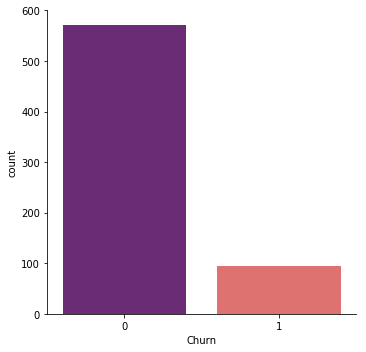

In [264]:
sns.catplot( x = 'Churn', kind = 'count', data = churn.toPandas(), palette='magma')

In [265]:
dataset_size = float(train.select('Churn').count())
numPositives = train.select("Churn").where("Churn == 1").count()
per_one = (float(numPositives)/float(dataset_size))*100
print("The number of churn are: {}".format(numPositives))
print("Percentage of churn are: {}".format(per_one))

The number of churn are: 79
Percentage of churn are: 14.575645756457565


In [266]:
numNegatives = float(dataset_size - numPositives)

BalanceRatio = numNegatives / dataset_size

print("BalanceRatio = {}".format(BalanceRatio))

BalanceRatio = 0.8542435424354243


In [267]:
train = train.withColumn("classWeights", when(train.Churn == 1, BalanceRatio).otherwise(1 - BalanceRatio))
train.select("classWeights").show()

+-------------------+
|       classWeights|
+-------------------+
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
|0.14575645756457567|
+-------------------+
only showing top 20 rows



In [268]:
lr = LogisticRegression(labelCol = 'Churn', featuresCol = 'features', weightCol = 'classWeights', maxIter = 20)

In [269]:
model = lr.fit(train)

In [270]:
predict_train = model.transform(train)
predict_test = model.transform(test)

In [271]:
predict_test.select("Churn", 'prediction').show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



In [272]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'Churn', predictionCol = "prediction",
                                             metricName = "accuracy")

accuracy = evaluator.evaluate(predict_test)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.808


In [273]:
y_true = predict_test.select("Churn")
y_true = y_true.toPandas()

y_pred = predict_test.select("prediction")
y_pred = y_pred.toPandas()

confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat

array([[90, 19],
       [ 5, 11]])

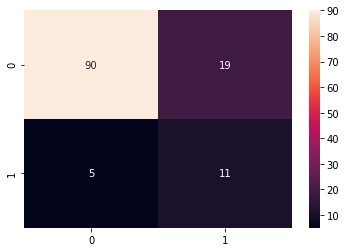

In [274]:
sns.heatmap(confusion_mat, annot = True)